# ***NoNino Project***

# Exploratory Data Analysis

Import Packages

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn pandas numpy tensorflow seaborn mplfinance


Looking in indexes: https://download.pytorch.org/whl/cu118


In [41]:
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns

import pandas as pd

import joblib

import mplfinance as mpf

import xgboost as xgb

import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, BatchNormalization
import tensorflow.keras.optimizers as optimize

import torch.nn as nn
import torch.optim as optim
import torch

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("/content/elnino.csv")

In [34]:
data = data.drop(columns=['Observation', ' Date', ' Year', ' Humidity'])

In [4]:
print(len(data))

178080


In [5]:
print(len(data) - len(data.loc[data[' Humidity'] == '.']))

112319


In [22]:
data = data.loc[data[' Humidity'] != '.']

In [23]:
print(data.columns)
print(f"Max and Min of Meridional Wins Respectively: Max:{max(data[' Meridional Winds'])} and Min:{min(data[' Meridional Winds'])}")

Index(['Observation', ' Year', ' Month', ' Day', ' Date', ' Latitude',
       ' Longitude', ' Zonal Winds', ' Meridional Winds', ' Humidity',
       ' Air Temp', ' Sea Surface Temp', 'Season', ' LatitudeScaled',
       ' LongitudeScaled', 'cluster'],
      dtype='object')
Max and Min of Meridional Wins Respectively: Max:13.0 and Min:-11.6


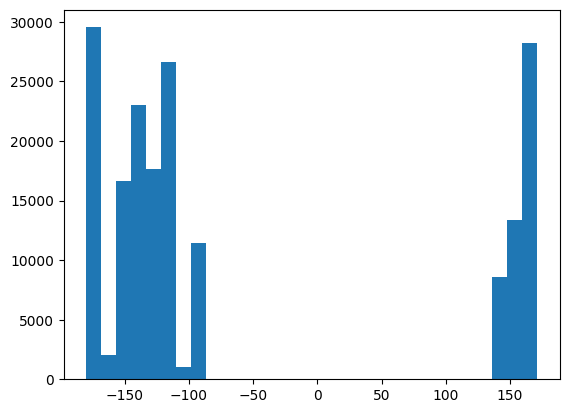

In [24]:
plt.hist(x=data[' Longitude'], bins=30)
plt.show()

In [25]:
print(data[' Month'].unique())

[ 3  8  9 10 11 12  1  2  4  5  6  7]


In [26]:
def season(x):
    if x >= 1 and x <= 2:
        return "Winter"
    elif x >= 3 and x <= 5:
        return "Spring"
    elif x >= 6 and x <= 8:
        return "Summer"
    elif x >= 9 and x <= 11:
        return "Autumn"
    else:
        pass  # Return NaN for invalid months

data['Season'] = data[' Month'].apply(season)

# Create a mapping for seasons to integers
season_map = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}

# Map the season names to integers
data['Season'] = data['Season'].map(season_map)
print(data.dtypes)
print(data['Season'].unique())

Observation            int64
 Year                  int64
 Month                 int64
 Day                   int64
 Date                  int64
 Latitude            float64
 Longitude           float64
 Zonal Winds         float64
 Meridional Winds    float64
 Humidity            float64
 Air Temp            float64
 Sea Surface Temp    float64
Season               float64
 LatitudeScaled      float64
 LongitudeScaled     float64
cluster                int32
dtype: object
[ 2.  3.  4. nan  1.]


In [27]:
scaler = StandardScaler()
data[[' LatitudeScaled', ' LongitudeScaled']] = scaler.fit_transform(data[[' Latitude', ' Longitude']])

In [14]:
num_clusters = 11
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the model to your data (using only the x and y columns)
data['cluster'] = kmeans.fit_predict(data[[' LatitudeScaled', ' LongitudeScaled']])

In [15]:
joblib.dump(kmeans, 'kmeans_model.pkl')

['kmeans_model.pkl']

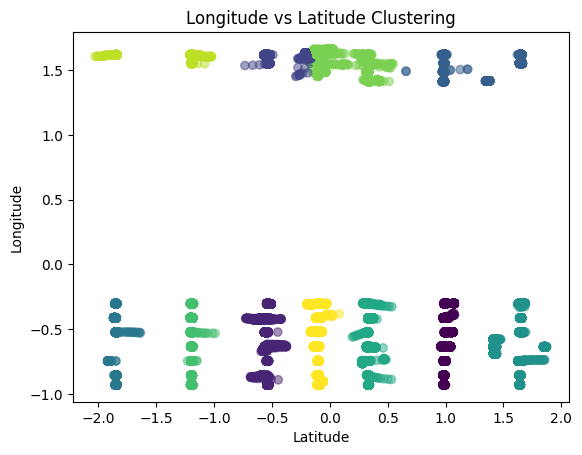

In [16]:
#plt.scatter(x=data[' Latitude'], y=data[' Longitude'], alpha=0.1)
plt.scatter(data[' LatitudeScaled'], data[' LongitudeScaled'], c=data['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Longitude vs Latitude Clustering")

plt.savefig('kMeansCluster.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution

plt.show()

In [ ]:
sns.pairplot(data)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7d74bfb6e3b0> (for post_execute):


KeyboardInterrupt: 

Maybe clustering them would be a smart idea

# Machine Learning

In [28]:
ttData = data[[' Zonal Winds',
       ' Meridional Winds', ' Air Temp', ' Sea Surface Temp', ' Month', ' Day', ' Latitude', ' Longitude', 'cluster', 'Season', ' Humidity']].dropna()

# Convert object columns to float, coercing errors
for column in data.select_dtypes(include=['object']).columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

ttData = ttData.dropna()
print(f"Samples: {len(ttData)}")

Samples: 85646


In [29]:
y = ttData[[' Meridional Winds', ' Air Temp', ' Sea Surface Temp', ' Humidity']]  # Features as NumPy array
X = ttData[[' Month', ' Day', ' Latitude', ' Longitude', 'cluster', 'Season']]    # Target as NumPy array

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
y

,Meridional Winds,Air Temp,Sea Surface Temp,Humidity
4059,2.1,26.80,27.02,81.2
4060,1.4,26.95,26.91,84.2
4061,2.2,26.98,26.78,84.9
4062,1.5,26.93,26.74,86.9
4063,1.9,27.01,26.82,87.6
...,...,...,...,...
178074,-5.3,27.52,28.17,81.3
178075,-0.4,26.04,28.14,94.1
178076,-3.3,25.80,27.87,93.2
178077,-4.8,27.17,27.93,81.3


In [32]:
# Create the XGBoost regressor
xgb_model = xgb.XGBRegressor()

# Wrap it with MultiOutputRegressor
xgboost = MultiOutputRegressor(xgb_model)

# Fit the model
xgboost.fit(X_train, y_train)

# Make predictions
predictions = xgboost.predict(X_test)

In [33]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Squared Error: {mae}')

print(f"Predictions: {predictions.flatten()[0:6]}")
flattened_list = [item for sublist in y_test.values.tolist() for item in sublist]
print(f"Actuals: {flattened_list[0:6]}")

Mean Squared Error: 1.3632242970031392
Predictions: [ 3.243357  23.61813   24.280167  79.84623    0.7222776 28.18986  ]
Actuals: [2.7, 22.64, 23.16, 71.5, 1.0, 28.72]


That represents total error

In [34]:
# Calculate MSE and NMSE for each output
nmse_values = {}
for i, col in enumerate(y_test.columns):
    mse = np.mean((y_test[col].values - predictions[:, i]) ** 2)
    variance = np.var(y_test[col].values)
    nmse = mse / variance if variance != 0 else float('inf')  # Avoid division by zero
    nmse_values[col] = nmse
print(nmse_values)

{' Meridional Winds': 0.42070950082000036, ' Air Temp': 0.15789056513100644, ' Sea Surface Temp': 0.11247470952417876, ' Humidity': 0.5229856797913129}


In [35]:
# Save each model in the MultiOutputRegressor
for i, xgboost in enumerate(xgboost.estimators_):
    xgboost.save_model(f'xgboost_model_{i}.json')

# Deep Learning

In [43]:
def create_model(input_shape, learning_rate=0.001):  # Set default learning rate
    model = keras.Sequential([
        Input(shape=input_shape),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4)  # Output layer for your specific task
    ])
    # Create the Adam optimizer with the specified learning rate
    optimizer = optimize.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create and train the model with a specific learning rate
model = create_model(X_train.shape[1:], learning_rate=0.001)  # Change learning rate here

In [44]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 260.1047 - val_loss: 10.0162
Epoch 2/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 9.5379 - val_loss: 8.2609
Epoch 3/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 8.7523 - val_loss: 7.5558
Epoch 4/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.4703 - val_loss: 7.2911
Epoch 5/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 8.3380 - val_loss: 8.0201
Epoch 6/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 8.2842 - val_loss: 7.5844
Epoch 7/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 8.1754 - val_loss: 7.4473
Epoch 8/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.0728 - val_loss: 7.7169
Epoch 9/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.1310 - val_loss: 7.1138
Epoch 10/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 7.9280 - val_loss: 7.3180
Epoch 11/20
1713/1713 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 8.0178 - val_loss: 7.6978
Epoch 12/20
1713/1713 ━━━━━

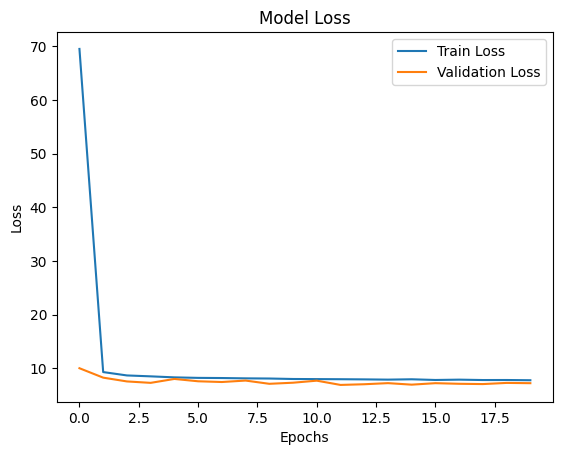

In [57]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('modelLoss.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution

plt.show()

In [56]:
model.save("my_model.h5")  # Saves as an HDF5 file

In [46]:
print(f"Predictions: {predictions.flatten()[0:6]}")
flattened_list = [item for sublist in y_test.values.tolist() for item in sublist]

print(f"Actuals: {flattened_list[0:6]}")

Predictions: [ 2.2476325 24.911993  25.425694  80.91822    1.0083728 27.383451 ]
Actuals: [2.7, 22.64, 23.16, 71.5, 1.0, 28.72]


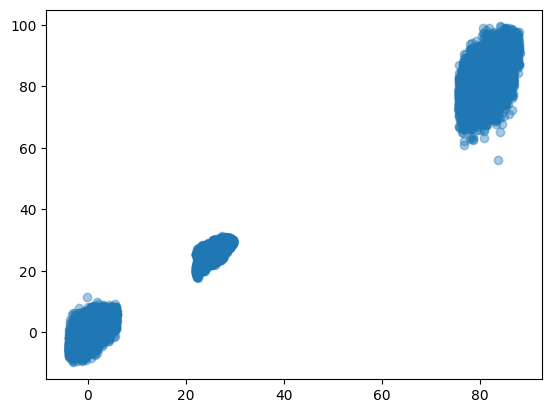

In [58]:
plt.scatter(x=predictions.flatten(), y=flattened_list, alpha = 0.4)
plt.savefig('predictions.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution
plt.show()

Pretty accurate as it follow a y=x correlation line

# Graphs

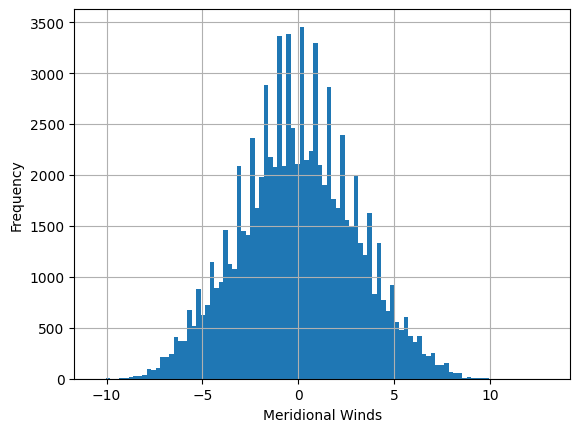

In [59]:
plt.hist(x=ttData[' Meridional Winds'], bins=100)
plt.xlabel("Meridional Winds")
plt.ylabel("Frequency")
plt.grid()
plt.savefig('meridionalhist.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution
plt.show()

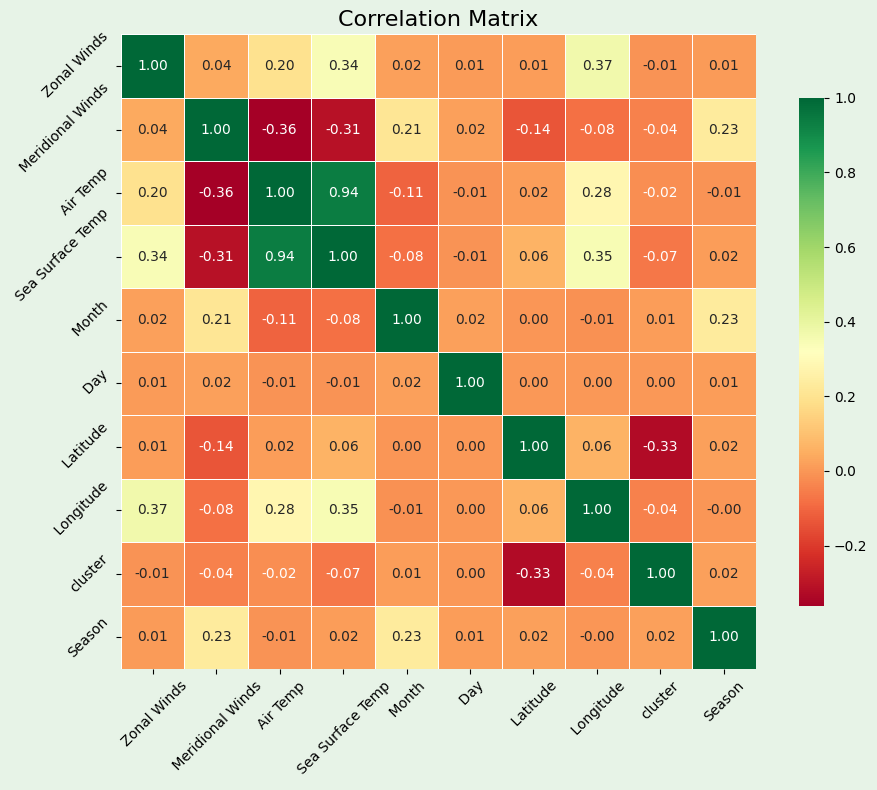

In [86]:
# Step 1: Calculate the correlation matrix
correlation_matrix = ttData.corr()

# Step 2: Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8), facecolor="#e7f3e7")  # Adjust the size as needed

farm_colors = sns.color_palette("RdYlGn", as_cmap=True)  # Red to Yellow to Green

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=farm_colors,
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

# Set titles and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

plt.savefig('correlationMatrix.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution

plt.show()

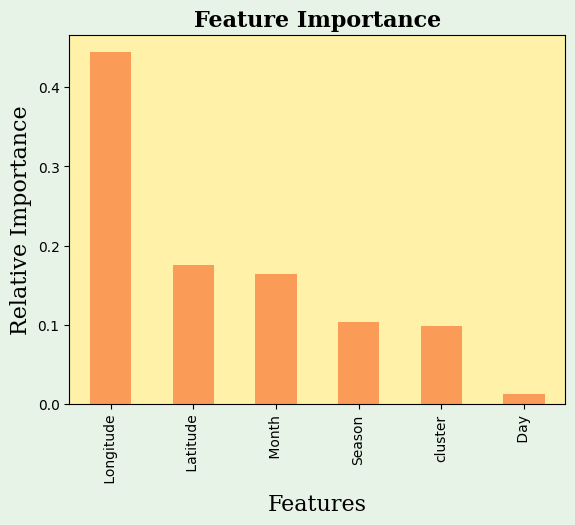

In [93]:
# Generate the custom "farmy" color palette
farm_colors = sns.color_palette("RdYlGn", 10)  # 10 color stops for variety

# Set swapped colors for background and bars
background_color = "#e7f3e7"       # Soft, light green for the figure background
axes_color = farm_colors[4]        # Mid-green for the inner plot background (previously the bar color)
bar_color = farm_colors[2]         # Light greenish-yellow for the bars (previously the axes color)
#label_color = farm_colors[9]       # Dark green for text for better contrast

# Plot feature importances with swapped farm-themed colors
fig, ax = plt.subplots()

# Set figure and axis background colors
fig.patch.set_facecolor(background_color)
ax.set_facecolor(axes_color)

# Plot the feature importances with the new bar color
feature_imp = pd.Series(xgboost.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp.plot(kind='bar', ax=ax, color=bar_color)

# Set axis label and title colors
ax.set_ylabel('Relative Importance', color="black", family='serif', fontsize=16)
ax.set_xlabel('Features', color="black", family='serif', fontsize=16)
plt.title('Feature Importance', color="black", family='serif', fontsize=16, fontweight='bold')

# Customize ticks and spines
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
for spine in ax.spines.values():
    spine.set_edgecolor("black")

plt.savefig('featureImportant.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution

# Show the plot
plt.show()

In [89]:
data.head(2)

,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Air Temp,Sea Surface Temp,Season,LatitudeScaled,LongitudeScaled,cluster
0,3,7,-0.02,-109.46,-6.8,0.7,26.14,26.24,2.0,-0.107707,-0.409525,10
1,3,8,-0.02,-109.46,-4.9,1.1,25.66,25.97,2.0,-0.107707,-0.409525,10


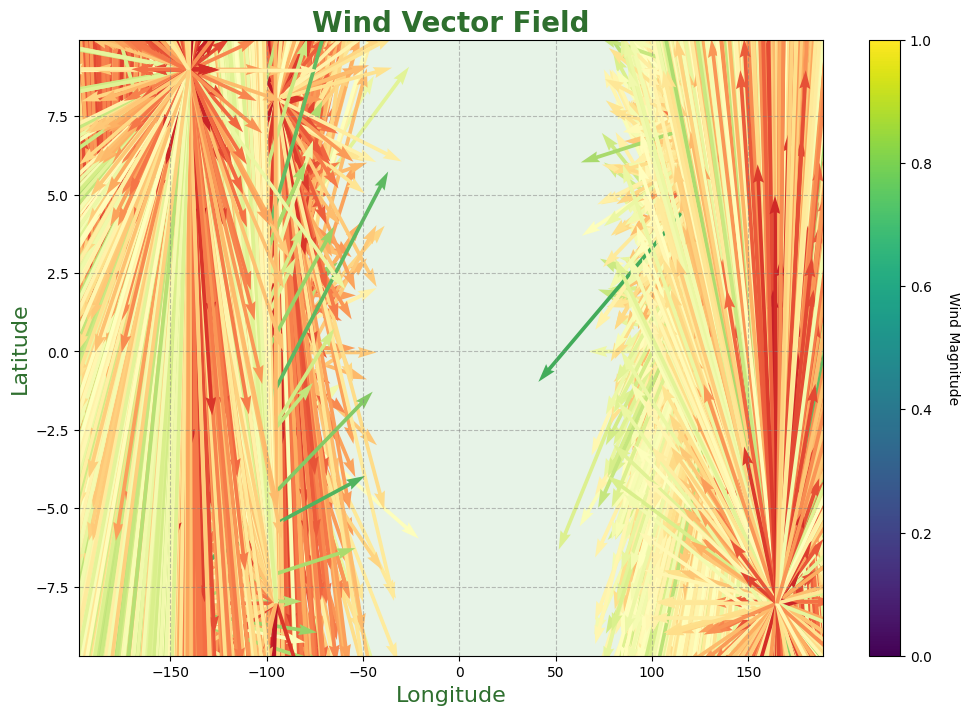

In [60]:
# Calculate the magnitude of the wind vectors
data['Magnitude'] = np.sqrt(data[' Zonal Winds']**2 + data[' Meridional Winds']**2)

# Set the figure size
plt.figure(figsize=(12, 8))
plt.gca().set_facecolor('#e7f3e7')  # Soft light green background

# Normalize the magnitude for color mapping
norm = plt.Normalize(data['Magnitude'].min(), data['Magnitude'].max())
cmap = sns.color_palette("RdYlGn", as_cmap=True)

# Create a quiver plot
quiver = plt.quiver(
    data[' Longitude'],
    data[' Latitude'],
    data[' Zonal Winds'],
    data[' Meridional Winds'],
    color=cmap(norm(data['Magnitude'])),
    angles='xy',
    scale_units='xy',
    scale=0.1,
    width=0.005
)

# Add a colorbar
cbar = plt.colorbar(quiver, label='Wind Magnitude', orientation='vertical')
cbar.set_label('Wind Magnitude', rotation=270, labelpad=20)

# Set title and labels
plt.title("Wind Vector Field", fontsize=20, fontweight='bold', color='#2E6F2E')
plt.xlabel("Longitude", fontsize=16, color='#2E6F2E')
plt.ylabel("Latitude", fontsize=16, color='#2E6F2E')
plt.grid(True, color='gray', linestyle='--', alpha=0.5)
plt.savefig('windvector.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution

plt.show()

In [110]:
# Assuming 'Month' and 'Day' can be combined into a single datetime for plotting
data['Date'] = pd.to_datetime(data[[' Month', ' Day']].assign(Year=2023))  # Change year as appropriate

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data[' Magnitude'], marker='o', linestyle='-', color='blue')
plt.title('Wind Magnitude Over Time', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Wind Magnitude', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month] is missing

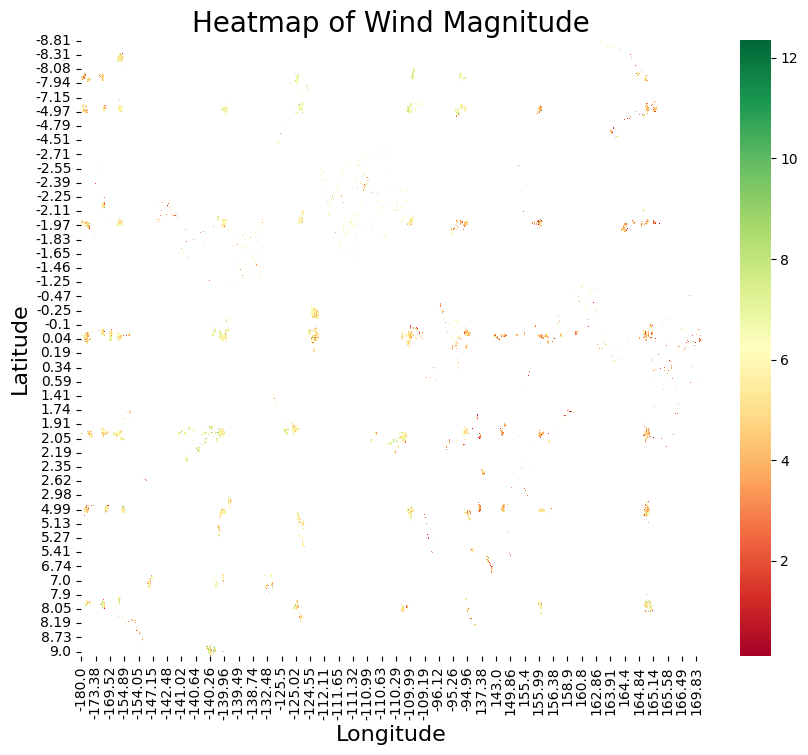

In [112]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.pivot_table(values='Magnitude', index=' Latitude', columns=' Longitude'), cmap='RdYlGn')
plt.title('Heatmap of Wind Magnitude', fontsize=20)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.show()

In [114]:
data['Season'].unique()

array([ 2.,  3., nan,  1.])

<Figure size 1000x600 with 0 Axes>

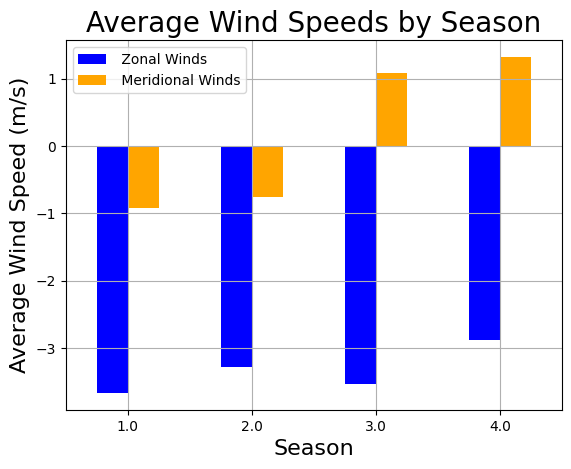

In [61]:
# Assuming 'Season' is already defined in your data
avg_wind_by_season = data.groupby('Season')[[' Zonal Winds', ' Meridional Winds']].mean().reset_index()

plt.figure(figsize=(10, 6))
avg_wind_by_season.plot(kind='bar', x='Season', color=['blue', 'orange'])
plt.title('Average Wind Speeds by Season', fontsize=20)
plt.ylabel('Average Wind Speed (m/s)', fontsize=16)
plt.xlabel('Season', fontsize=16)
plt.xticks(rotation=0)
plt.grid(True)
plt.savefig('seasonalwindspeed.png', format='png', dpi=300)  # Saves as a PNG file with 300 DPI resolution

plt.show()

In [55]:
years = data[' Year'].unique()
for year in years:
  year_df = data.loc[data[' Year'] == year]
  months = year_df[' Month'].unique()
  for month in months:


SyntaxError: incomplete input (<ipython-input-55-eca89dc7327f>, line 5)